In [1]:
import data_utils

dataset = data_utils.get_dataset()
display(dataset.head())
dataset.shape

,AFEC_DPTO,AFEC_EDADR,AFEC_EDUC,AFEC_GENERO,AFEC_GETNICO,AFEC_MPIO,AFEC_PARENTESCO,AFEC_POBESPECIAL,AFEC_REGAFILIACION,AFEC_TIPOPER,...,PET_MPIO,PET_TIPOPER,PQR_CANAL,PQR_CLASE_SNS,PQR_ESTADO,PQR_GRUPOALERTA,PQR_TIPOATENCION,PQR_TIPOPETICION,RIESGO_VIDA,TRIM
0,bogota d.c.,de 13 a 17 años,ninguno,mujer,no aplica,bogotá,otro,no aplica,subsidiado,natural,...,bogotá,juridica,escrito,pqr,cerrado,0,peticion directa,reclamo,no,trim i
1,nariño,de 0 a 5 años,ninguno,hombre,no aplica,puerres,otro,no aplica,subsidiado,natural,...,puerres,natural,telefonico,pqr,cerrado,0,0,reclamo,no,trim i
2,valle,de 13 a 17 años,secundaria,hombre,no aplica,cali,abuelo (a),no aplica,contributivo,natural,...,cali,natural,telefonico,pqr,cerrado,0,0,reclamo,no,trim i
3,huila,de 13 a 17 años,universitario incompleto,hombre,no aplica,neiva,padre,no aplica,contributivo,natural,...,neiva,natural,personalizado,pqr,cerrado,0,0,reclamo,no,trim i
4,risaralda,de 13 a 17 años,ninguno,hombre,no aplica,dosquebradas,padre,persona en condición de discapacidad,contributivo,natural,...,dosquebradas,natural,personalizado,pqr,pendiente (avance),0,0,reclamo,si,trim i


(2375371, 46)

## Special case: AFEC_DPTO

States names can take similar names for a same state, and given that there are relatively few states, it's possible to manually fix these values to avoid duplicates in classe values.

Some features are writen in different ways, for example, 'ARCHIPIELAGO DE SAN ANDRES, PROVIDENCIA Y SANTA CATALINA', 'SAN ANDRES' and 'SAN ANDRÉS' are the same state. Same for 'BOGOTA D.C' and 'BOGOTA D.C.'

In [2]:
dataset[['AFEC_DPTO']].drop_duplicates().sort_values(by=['AFEC_DPTO'])

,AFEC_DPTO
86,0
1026,amazonas
10,antioquia
135,arauca
4057,"archipielago de san andres, providencia y sant..."
11,atlantico
9,bogota d.c
0,bogota d.c.
92,bolivar
77,boyaca


In [3]:
dataset = data_utils.clean_afec_dpto(dataset)

dataset[['AFEC_DPTO']].drop_duplicates().sort_values(by=['AFEC_DPTO'])

,AFEC_DPTO
86,0
1026,amazonas
10,antioquia
135,arauca
11,atlantico
0,bogota d.c.
92,bolivar
77,boyaca
5,caldas
522,caqueta


### RIESGO_VIDA


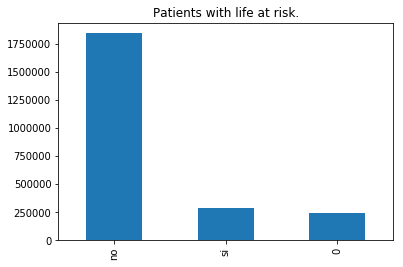

In [4]:

riesgo_vida = dataset['RIESGO_VIDA'].value_counts()
riesgo_vida.plot(kind='bar', title='Patients with life at risk.');

We remove rows with missing info in our target column

C:\Users\mrugeles\Documents\Data discipline\projects\Supersalud-PQRSD\data_utils.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataset['RIESGO_VIDA'] = np.where(dataset['RIESGO_VIDA'] == 'si', 1,0)


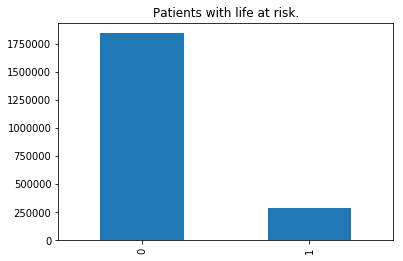

In [5]:
dataset = data_utils.clean_riesgo_vida(dataset)

riesgo_vida = dataset['RIESGO_VIDA'].value_counts()
riesgo_vida.plot(kind='bar', title='Patients with life at risk.');

### CIE_10

In 'Data understanding' notebook we see CIE_10 was way too many missing values. '0' value is the most common value in the column so is not a good candidate for imputing values. But as the column contains descriptions about the patient's illness, we want to keep it as it can provide a signal to predict if the patient's life is at risk.

In [6]:
dataset = data_utils.clean_cie_10(dataset)
dataset.shape

(281311, 46)

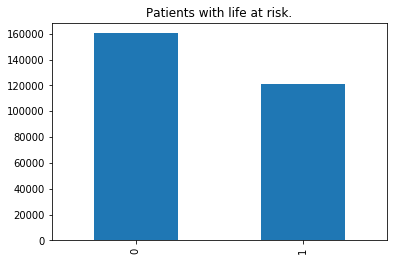

In [7]:
riesgo_vida = dataset['RIESGO_VIDA'].value_counts()
riesgo_vida.plot(kind='bar', title='Patients with life at risk.');

Removing records with CIE_10 = 0 reduces drastically the dataset from 2'375.371 to 281.311 records but it provided a huge improvement in the target's balance.

## Removing fields

Acording to the oficial documentation, fields "IDRANGOEDADES", "ID_MES" and "PQR_GRUPOALERTA" have not statistical use, so they are removed from the dataset.

Feature "PQR_ESTADO" has a significant statistical value that may bias the model. Once a PQRS enters the system, it goes through a series of states before the case is closed. First, Historycally, patients with life at risk can have a tendency to have a certain state or a relationship with and another feature (i.e patient's with life at risk may have most of their states as closed as they may have priority over other cases), so including "PQR_ESTADO" will make the model to make predictions over a feature that will not be statiastic relevant when introducing a new PQRS (When a new PQRS enters the system it will have a default state that is very unlikely to have the final state from the original data set).

### Redundant features
These features represent the same data, so we can keep only the codes and loose the descripion.

* COD_MACROMOT = MACROMOTIVO
* COD_MOTGEN = MOTIVO_GENERAL
* COD_MOTESP = MOTIVO_ESPECIFICO
* ENT_COD_DEPTO = ENT_DPTO
* ENT_COD_MPIO = ENT_MPIO
* PET_COD_DEPTO = PET_DPTO

In [8]:
dataset = data_utils.remove_features(dataset)

display(dataset.head(n = 5))
dataset.shape

,AFEC_DPTO,AFEC_EDADR,AFEC_EDUC,AFEC_GENERO,AFEC_GETNICO,AFEC_MPIO,AFEC_PARENTESCO,AFEC_POBESPECIAL,AFEC_REGAFILIACION,AFEC_TIPOPER,...,PATOLOGIA_TIPO,PET_COD_DEPTO,PET_MPIO,PET_TIPOPER,PQR_CANAL,PQR_CLASE_SNS,PQR_TIPOATENCION,PQR_TIPOPETICION,RIESGO_VIDA,TRIM
0,bogota d.c.,de 13 a 17 años,ninguno,mujer,no aplica,bogotá,otro,no aplica,subsidiado,natural,...,problemas relacionados con facilidades de aten...,11,bogotá,juridica,escrito,pqr,peticion directa,reclamo,0,trim i
2,valle,de 13 a 17 años,secundaria,hombre,no aplica,cali,abuelo (a),no aplica,contributivo,natural,...,problemas relacionados con facilidades de aten...,76,cali,natural,telefonico,pqr,0,reclamo,0,trim i
3,huila,de 13 a 17 años,universitario incompleto,hombre,no aplica,neiva,padre,no aplica,contributivo,natural,...,problemas relacionados con facilidades de aten...,41,neiva,natural,personalizado,pqr,0,reclamo,0,trim i
4,risaralda,de 13 a 17 años,ninguno,hombre,no aplica,dosquebradas,padre,persona en condición de discapacidad,contributivo,natural,...,epilepsia,66,dosquebradas,natural,personalizado,pqr,0,reclamo,1,trim i
6,bogota d.c.,de 13 a 17 años,ninguno,hombre,no aplica,bogotá,otro,no aplica,subsidiado,natural,...,problemas relacionados con facilidades de aten...,11,bogotá,juridica,escrito,pqr,peticion directa,reclamo,0,trim i


(281311, 36)

In [ ]:
dataset['SERVICIO_NEGADO'] = dataset['COD_MOTGEN'].apply(lambda value: 1 if value == '101' or  value == '103' else 0)
print(set(dataset['SERVICIO_NEGADO'].values))
dataset[(dataset['SERVICIO_NEGADO'] == 1) & (dataset['RIESGO_VIDA'] == 1)].shape

{0, 1}


(84049, 37)

In [ ]:
dataset.to_csv("datasets/dataset_clean.csv", index = False)

### Imputing Values

In [ ]:
# Columns with zero values
col_zero_values = set(dataset.columns[dataset.eq('0').mean() > 0])
print(len(col_zero_values))
print(col_zero_values)

26
{'ENT_MPIO_DANE', 'AFEC_GETNICO', 'ENT_AMBITOIVC', 'AFEC_EDUC', 'PET_COD_DEPTO', 'AFEC_POBESPECIAL', 'IDPATOLOGIA_2', 'PATOLOGIA_TIPO', 'PET_TIPOPER', 'ENT_COD_SNS', 'AFEC_MPIO', 'ENT_COD_MPIO', 'ENT_TIPOVIG', 'AFEC_GENERO', 'ENT_NOMBRE', 'PET_MPIO', 'ALTO_COSTO', 'AFEC_PARENTESCO', 'PQR_TIPOATENCION', 'AFEC_EDADR', 'AFEC_REGAFILIACION', 'PATOLOGIA_1', 'AFEC_TIPOPER', 'ENT_COD_DEPTO', 'ENT_TIPOVIG_SNS', 'AFEC_DPTO'}


C:\Users\mrugeles\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [ ]:
dataset = data_utils.impute_values("datasets/dataset_clean.csv", "datasets/dataset_clean_imputed.csv")


C:\Users\mrugeles\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3214: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
